# 1. IMPORT LIBRARIES

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from data_processing import load_data, get_column_index, train_test_split, standardize, one_hot_encode
from visualization import plot_heatmap

# 2. LOAD DATA

In [6]:
data, header = load_data('../data/processed/data_after_eda.csv')

print(f"Shape: {data.shape}")
print(f"Data:\n {data[:5]}")

Shape: (10127, 20)
Data:
 [['Existing Customer' 45 'M' 3 'High School' 'Married' '$60K - $80K'
  'Blue' 39 5 1 3 12691.0 777 11914.0 1.335 1144 42 1.625 0.061]
 ['Existing Customer' 49 'F' 5 'Graduate' 'Single' 'Less than $40K'
  'Blue' 44 6 1 2 8256.0 864 7392.0 1.541 1291 33 3.714 0.105]
 ['Existing Customer' 51 'M' 3 'Graduate' 'Married' '$80K - $120K' 'Blue'
  36 4 1 0 3418.0 0 3418.0 2.594 1887 20 2.333 0.0]
 ['Existing Customer' 40 'F' 4 'High School' 'Unknown' 'Less than $40K'
  'Blue' 34 3 4 1 3313.0 2517 796.0 1.405 1171 20 2.333 0.76]
 ['Existing Customer' 40 'M' 3 'Uneducated' 'Married' '$60K - $80K'
  'Blue' 21 5 1 0 4716.0 0 4716.0 2.175 816 28 2.5 0.0]]


# 3. TARGET AND FEATURES

In [7]:
target_col = 'Attrition_Flag'
target_idx = get_column_index(header, target_col)

y_raw = data[:, target_idx]

feature_indices = [i for i in range(len(header)) if i != target_idx]
X_raw = data[:, feature_indices]
feature_names = [header[i] for i in feature_indices]

print(f"Shape X_raw: {X_raw.shape}")
print(f"Shape y_raw: {y_raw.shape}")

Shape X_raw: (10127, 19)
Shape y_raw: (10127,)


# 4. HANDLE NUMERIC & CATEGORICAL

In [8]:
X_processed = np.zeros(X_raw.shape, dtype=float)

num_cols_final = []
cat_cols_final = []

for i, col_name in enumerate(feature_names):
    col_data = X_raw[:, i]
    
    try:
        col_numeric = col_data.astype(float)
        
        mean = np.mean(col_numeric)
        std = np.std(col_numeric)
        
        if std == 0: std = 1
            
        X_processed[:, i] = (col_numeric - mean) / std
        num_cols_final.append(col_name)
        
    except ValueError:
        unique_vals, indices = np.unique(col_data, return_inverse=True)
        X_processed[:, i] = indices
        cat_cols_final.append(col_name)

y_processed = np.where(y_raw == 'Attrited Customer', 1, 0)

print(f"- Numeric cols ({len(num_cols_final)}): {num_cols_final}")
print(f"- Categorical cols ({len(cat_cols_final)}): {cat_cols_final}")

- Numeric cols (14): ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
- Categorical cols (5): ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


# 5. FEATURE SELECTION

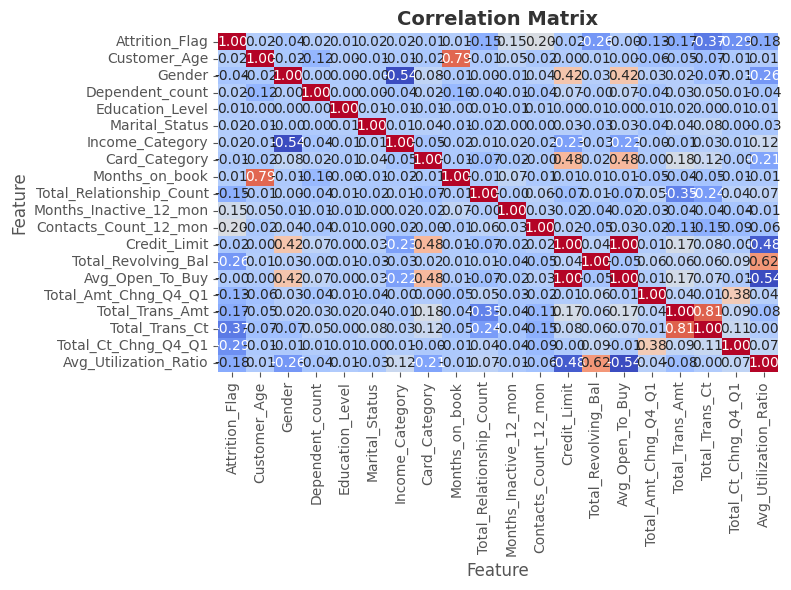

Checking Multicollinearity (Threshold=0.75):
Customer_Age vs Months_on_book (0.79) -> DROP: Months_on_book
Credit_Limit vs Avg_Open_To_Buy (1.00) -> DROP: Avg_Open_To_Buy
Total_Trans_Amt vs Total_Trans_Ct (0.81) -> DROP: Total_Trans_Amt
Dropped: ['Avg_Open_To_Buy', 'Months_on_book', 'Total_Trans_Amt']
------------------------------
Shape X_final: (10127, 16)
Numeric: 11, Categorical: 5
[[-0.16540558  1.          0.50336813  3.          1.          2.
   0.          0.76394261 -1.32713603  0.49240377  0.4466219  -0.47342222
   2.62349444 -0.97389518  3.8340026  -0.77588223]
 [ 0.33357038  0.          2.04319867  2.          2.          4.
   0.          1.40730617 -1.32713603 -0.41161598 -0.04136665 -0.36666682
   3.56329284 -1.35734038 12.60857291 -0.61627565]
 [ 0.58305837  1.          0.50336813  2.          1.          3.
   0.          0.12057905 -1.32713603 -2.21965548 -0.5736978  -1.42685834
   8.36721381 -1.91120566  6.80786367 -0.99715499]]


In [9]:
data_corr = np.column_stack((y_processed, X_processed))
names = ['Attrition_Flag'] + feature_names
corr_matrix = np.corrcoef(data_corr, rowvar=False)

plot_heatmap(corr_matrix, names, names, 'Correlation Matrix', 'Feature', 'Feature', fmt='.2f', cmap='coolwarm')

threshold = 0.75
drop_cols = set()
n_feats = len(feature_names)
target_corr = np.abs(corr_matrix[0, 1:])

print(f"Checking Multicollinearity (Threshold={threshold}):")
for i in range(n_feats):
    for j in range(i + 1, n_feats):
        if abs(corr_matrix[i+1, j+1]) > threshold:
            feat_i, feat_j = feature_names[i], feature_names[j]
            score_i, score_j = target_corr[i], target_corr[j]
            drop = feat_j if score_i > score_j else feat_i
            drop_cols.add(drop)
            print(f"{feat_i} vs {feat_j} ({corr_matrix[i+1, j+1]:.2f}) -> DROP: {drop}")

if drop_cols:
    drop_idx = [feature_names.index(c) for c in drop_cols]
    X_final = np.delete(X_processed, drop_idx, axis=1)
    names_final = [n for n in feature_names if n not in drop_cols]
    print(f"Dropped: {list(drop_cols)}")
else:
    X_final, names_final = X_processed, feature_names
    print("No features dropped.")

num_final = [c for c in num_cols_final if c in names_final]
cat_final = [c for c in cat_cols_final if c in names_final]

print("-" * 30)
print(f"Shape X_final: {X_final.shape}")
print(f"Numeric: {len(num_final)}, Categorical: {len(cat_final)}")
print(X_final[:3])

# 6. TRAIN, TEST SPLIT

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_processed, test_size=0.2, random_state=42)

print(f"{'':<10} | {'Samples':<10} | {'Churn Rate':<10}")
print("-" * 45)
print(f"{'Train':<10} | {X_train.shape[0]:<10} | {np.mean(y_train)*100:.2f}%")
print(f"{'Test':<10} | {X_test.shape[0]:<10} | {np.mean(y_test)*100:.2f}%")

header_str = ",".join(header)
np.savetxt('../data/processed/processed_data.csv', data, delimiter=',', header=header_str, fmt='%s', comments='', encoding='utf-8')
np.save('../data/processed/X_train.npy', X_train)
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)  

           | Samples    | Churn Rate
---------------------------------------------
Train      | 8102       | 16.05%
Test       | 2025       | 16.15%
